# 범죄 분석 보고서 Analysis Report - Crime
# 음주운전 적발횟수 예측

공공데이터를 활용하여 2020년 1월의 음주운전 적발 횟수를 예측해보았습니다.   
공공데이터포털에는 2007.01.01 - 2020.03.01의 음주운전 적발기록 데이터가 있습니다.   
그중 예측 대상인 2020년을 기준으로 최근 5년인 2015 - 2019년을 훈련데이터로 두었습니다.   
2020년 02월 - 03월은 코로나-19의 영향으로 기존의 데이터로 설명되기 어렵다고 판단하였습니다.  
따라서 2020년 01월을 예측 대상으로 선정하였습니다. 

In [1]:
# 데이터 전처리
import re
import os
import numpy as np
import pandas as pd
from datetime import datetime 

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 경고 안보이게
import warnings
warnings.filterwarnings(action='ignore')

## 데이터 불러오기  
데이터 : 경찰청 음주운전적발기록 (2007.01.01-2020.03.01)  
출처 : [공공데이터포털](https://www.data.go.kr/data/15043308/fileData.do)

In [2]:
%rm Data/.DS_Store

rm: Data/.DS_Store: No such file or directory


In [3]:
data = pd.DataFrame()
for f in os.listdir('data/'):
    if int(re.compile('\d+').search(f).group()) >= 2015:
        temp = pd.read_csv(f'data/{f}', encoding='cp949')
        temp = temp.rename(columns={'알콜농도 ':'알콜농도'})
        data = pd.concat([data, temp], axis = 0)

인덱스 재정렬

In [4]:
data.reset_index(drop = True, inplace = True)

## 데이터 살펴보기

In [5]:
data.head()

,적발횟수,알콜농도,측정거부여부,측정일시,연번,성별,나이,관할경찰서
0,1,0.083,N,2015-01-01 00:00,NaN,NaN,NaN,NaN
1,1,0.155,N,2015-01-01 00:01,NaN,NaN,NaN,NaN
2,1,0.074,N,2015-01-01 00:02,NaN,NaN,NaN,NaN
3,1,0.204,N,2015-01-01 00:02,NaN,NaN,NaN,NaN
4,1,0.174,N,2015-01-01 00:05,NaN,NaN,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977968 entries, 0 to 977967
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   적발횟수    977968 non-null  int64  
 1   알콜농도    977968 non-null  float64
 2   측정거부여부  977968 non-null  object 
 3   측정일시    977968 non-null  object 
 4   연번      24802 non-null   float64
 5   성별      24802 non-null   object 
 6   나이      24789 non-null   float64
 7   관할경찰서   24802 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 59.7+ MB


#### ['측정일시'] 열 object → datetime 데이터타입 변환   

In [7]:
data['측정일시'] = pd.to_datetime(data['측정일시'])

#### ['측정일시'] 열에서 ['date'] 열 추출

In [8]:
data['date'] = data['측정일시'].apply(lambda x : x.date())
data[['측정일시', 'date']].sample()

,측정일시,date
518069,2016-04-24 16:55:00,2016-04-24


#### date별 적발횟수의 합(sum) 데이터 생성   

In [9]:
date_case = data.groupby(['date']).sum()[['적발횟수']]
date_case.head()

,적발횟수
date,
2015-01-01,365
2015-01-02,475
2015-01-03,575
2015-01-04,607
2015-01-05,444


#### train-test 분리하기
train : 2015 - 2019   
test : 2020년 1월   

In [10]:
# 2015 - 2019
train = date_case.iloc[:1826]

# 2020.01
test = date_case.iloc[1826:1857]

print(f'train : {train.index[0]} - {train.index[-1]}')
print(f'test : {test.index[0]} - {test.index[-1]}')

train : 2015-01-01 - 2019-12-31
test : 2020-01-01 - 2020-01-31


# 시계열분석

## 정상성 판단
- 평균, 분산이 시점에 의존하지 않는다.

### 1. 그래프 그려 판단하기

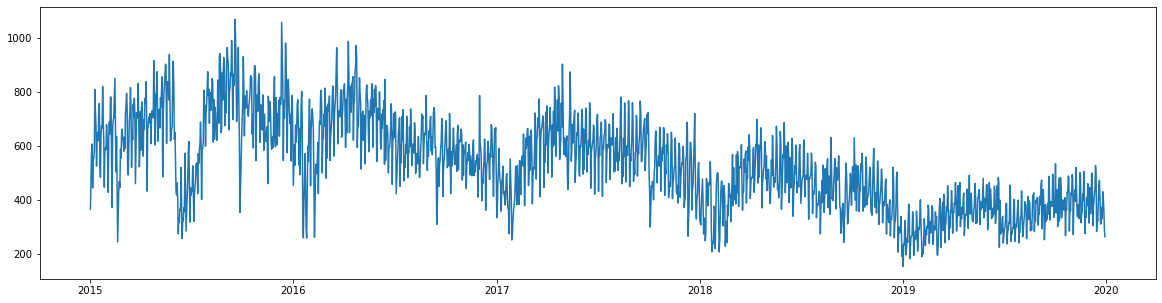

In [11]:
plt.figure(figsize=(20, 5))
plt.show(plt.plot(train.index, train['적발횟수']))

→ 평균/분산이 일정하지 않다.  
→ 계절성과 추세가 있다. 

**이동평균**

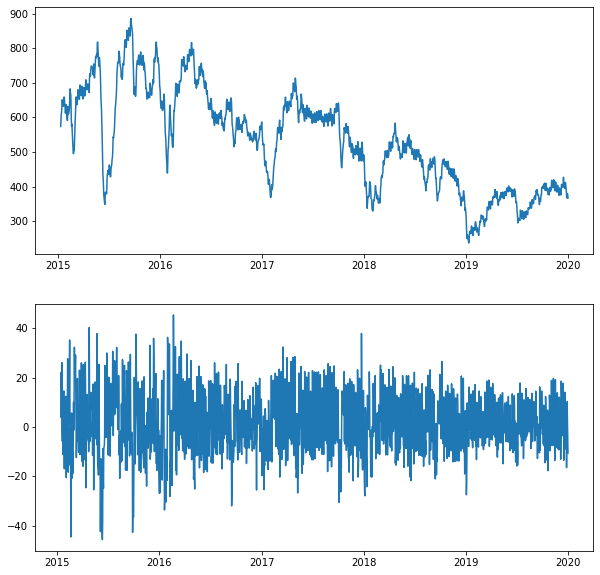

In [12]:
# 이동평균
plt.figure(figsize = (10, 10))
plt.subplot(211)
plt.plot(train.rolling(window=12).mean())
plt.subplot(212)
plt.plot(train.diff().rolling(window=12).mean())

→ 1차 차분하면 이동평균이 어느정도 일정해진다. 

### 2. ADF 검정

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train, autolag='AIC')
print('ADF statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF statistic: -2.579167094016626
p-value: 0.09737990109032113
Critical Values: {'1%': -3.4339861159726306, '5%': -2.863146142843122, '10%': -2.5676250581282964}


→ ADF statistic이 Critical Values의 5%보다 크고, p-value는 0.05보다 크다.  
비정상시계열이므로 정상시계열로 변환이 필요하다. 

### 3. 분해 시계열

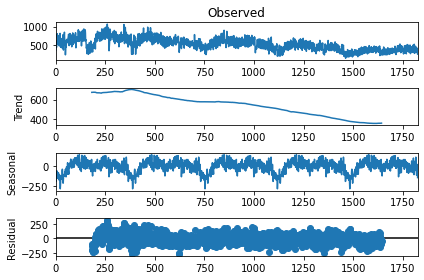

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(train.values, period=365, model='addictive')
fig = res.plot()

→ 계절성, 추세가 존재한다.   

💡 차분이 필요하다.  

## 시계열 모형 - ARIMA / SARIMAX

### ACF / PACF

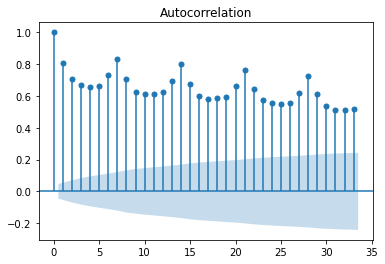

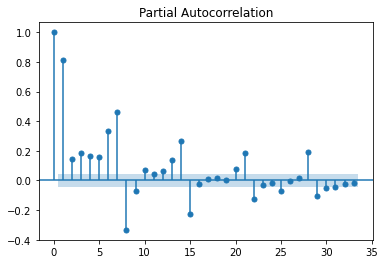

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF 자기상관그래프
plt.show(plot_acf(train))

# PACF 부분자기상관그래프
plt.show(plot_pacf(train))

→ p = 1, q = 1로 추정  
→ 계절성이 존재한다. 

### 최적의 p, q 찾기
AIC가 가장 낮은 값을 p, q로 설정한다. 

In [16]:
from statsmodels.tsa.stattools import arma_order_select_ic

arma_aic = arma_order_select_ic(train, max_ar=2, max_ma=2, ic='aic', trend='c')
print('ARMA(p,q) =', arma_aic['aic_min_order'],'is the best.')

ARMA(p,q) = (2, 2) is the best.


In [17]:
from statsmodels.tsa.arima_model import ARIMA

def arima_aic(p, d, q):
    pdq = []
    aic = []
    
    for x in range(0, p+1):
        for y in range(0, d+1):
            for z in range(0, q+1):
                try:
                    model = ARIMA(train, order=(x, y, z))
                    model_fit = model.fit(trend='c', full_output=True)
                    pdq.append(str(x)+str(y)+str(z))
                    aic.append(model_fit.aic)
                except:
                    pass
    return pd.DataFrame({'ARIMA':pdq, 'AIC':aic}).sort_values('AIC').head()

In [18]:
arima_aic(2,2,2)

,ARIMA,AIC
20,211,21520.354228
21,212,21527.755485
14,112,21530.051106
5,012,21534.553251
18,202,21539.803510


→ ARIMA의 경우 p=2, d=1, q=1이 최적이다.  

### ARIMA

In [19]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(2, 1, 1))
model_fit = model.fit(trend='c', full_output=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.적발횟수   No. Observations:                 1825
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10755.177
Method:                       css-mle   S.D. of innovations             87.708
Date:                Thu, 18 Mar 2021   AIC                          21520.354
Time:                        03:13:06   BIC                          21547.901
Sample:                    01-02-2015   HQIC                         21530.516
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1089      0.345     -0.316      0.752      -0.784       0.566
ar.L1.D.적발횟수     0.3977      0.026     15.053      0.000       0.346       0.449
ar.L2.D.적발횟수    -0.1393      0.025     -5.55

→ const의 P|Z|가 0.752로 유의하지 않다. 따라서 trend='nc'로 변경해준다.

In [20]:
model = ARIMA(train, order=(2, 1, 1))
model_fit = model.fit(trend='nc', full_output=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.적발횟수   No. Observations:                 1825
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10755.227
Method:                       css-mle   S.D. of innovations             87.711
Date:                Thu, 18 Mar 2021   AIC                          21518.454
Time:                        03:13:06   BIC                          21540.491
Sample:                    01-02-2015   HQIC                         21526.583
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.적발횟수     0.3976      0.026     15.051      0.000       0.346       0.449
ar.L2.D.적발횟수    -0.1394      0.025     -5.554      0.000      -0.189      -0.090
ma.L1.D.적발횟수    -0.8759      0.014    -62.05

잔차그래프

                 0
count  1825.000000
mean     -0.355182
std      87.771141
min    -386.469304
25%     -51.066046
50%       6.151111
75%      58.829477
max     323.969343

kurtosis : 0.5229993158616186
skew : -0.378946072630568


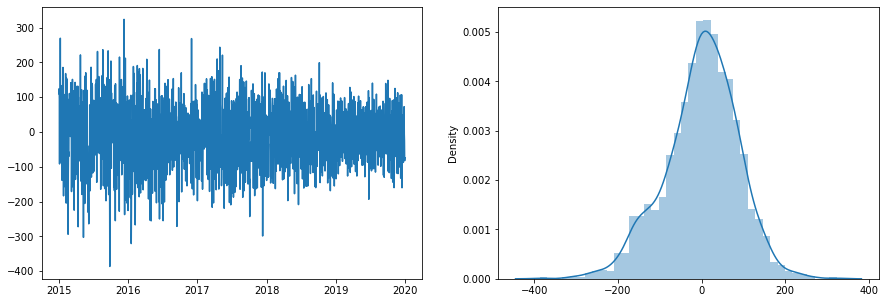

In [21]:
from scipy import stats

residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(residuals)
plt.subplot(122)
sns.distplot(residuals)
print(residuals.describe())
print(f'\nkurtosis : {stats.kurtosis(residuals[0])}\nskew : {stats.skew(residuals[0])}')

### SARIMAX

계절성 시계열 분석

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,1,7),
                 enforce_stationarity=False, enforce_invertibility=False).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              적발횟수   No. Observations:                 1826
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -10014.970
Date:                           Thu, 18 Mar 2021   AIC                          20041.941
Time:                                   03:13:09   BIC                          20074.944
Sample:                               01-01-2015   HQIC                         20054.120
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4728      0.023     20.439      0.000       0.427       0.518
ar.L2          0.0593      0.024      2.514      0.012       0.013       0.105
ma.L1         -0.8908      0.016    -54.128      0.000      -0.923      -0.859
ar.S.L7        0.0510      0.021      2.424      0.015       0.010       0.092
ma.S.L7       -0.9599      0.008   -124.650      0.000      -0.975      -0.945
sigma2      3740.1829     90.126     41.500      0.000    3563.539    3916.826
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               543.21
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                 0
count  1826.000000
mean     -0.062810
std      62.843842
min    -327.254189
25%     -31.206898
50%       1.720672
75%      35.600227
max     365.000000

kurtosis : 2.9277810120583343
skew : -0.4874627642711318


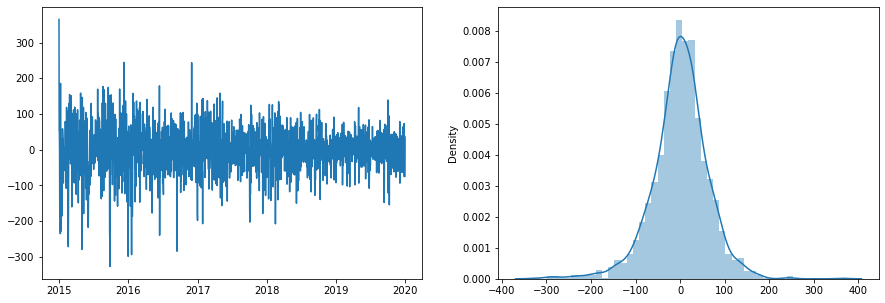

In [23]:
residuals = pd.DataFrame(sarima.resid)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(residuals)
plt.subplot(122)
sns.distplot(residuals)
print(residuals.describe())
print(f'\nkurtosis : {stats.kurtosis(residuals[0])}\nskew : {stats.skew(residuals[0])}')

### 예측

In [24]:
# ARIMA
pred_arima = model_fit.predict('2020-01-01', '2020-01-31', typ='levels').round()

# SARIMA
pred_sarima = sarima.predict('2020-01-01', '2020-01-31', typ='levels').round()

In [25]:
from sklearn.metrics import mean_squared_error
MSE_arima = mean_squared_error(test['적발횟수'], pred_arima.round())
MSE_sarima = mean_squared_error(test['적발횟수'], pred_sarima.round())

print(f'ARIMA MSE : {np.sqrt(MSE_arima)}\nSARIMA MSE : {np.sqrt(MSE_sarima)}')

ARIMA MSE : 91.27484195655202
SARIMA MSE : 80.97530487747484


→ 계절적 요인이 있어서 그런지 SARIMA의 RMSE가 더 낮게 나타났다.   

In [26]:
test['예측'] = pred_sarima.round()

In [27]:
def MPE(y_test, y_pred):
    return np.mean((y_test - y_pred) / y_test) * 100
MPE(test['적발횟수'], test['예측'])

-22.667717646823547

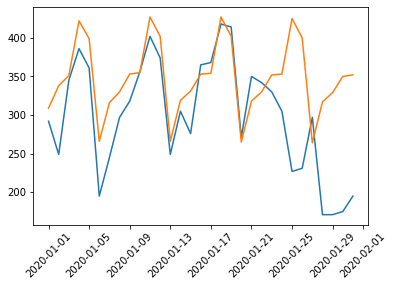

In [28]:
plt.xticks(rotation=45)
plt.plot(test['적발횟수'])
plt.plot(test['예측'])

1월 말부터 코로나가 국내에 유입되기 시작했다. 그로 인해 1월 20일 이후의 음주운전 적발건수가 급감하였다.   
그 점을 제외하고는 어느정도 예측이 일치한다. 